In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.sklearn

# spacy for lemmatization
import spacy

# Plotting tools
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import nltk

# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint

# Plotting tools
import matplotlib.pyplot as plt
%matplotlib inline

D:\Software\Anaconda3\envs\pytorch\lib\site-packages\past\builtins\misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
D:\Software\Anaconda3\envs\pytorch\lib\site-packages\joblib\backports.py:22: DeprecationWarning: The distutils package is deprecated and slated for removal in Python 3.12. Use setuptools or check PEP 632 for potential alternatives
  import distutils  # noqa
D:\Software\Anaconda3\envs\pytorch\lib\site-packages\sklearn\utils\multiclass.py:14: DeprecationWarning: Please use `spmatrix` from the `scipy.sparse` namespace, the `scipy.sparse.base` namespace is deprecated.
  from scipy.sparse.base import spmatrix
D:\Software\Anaconda3\envs\pytorch\lib\site-packages\sklearn\utils\optimize.py:18: DeprecationWarning: Please use `line_search_wolfe2` from the `scipy.optimize` namespace, the `scipy.optimize.linesearch` namespace is deprec

In [3]:
df = pd.read_csv('D:\Projects\Jupyter\Github Docs\datasets\preprocessed_word_correct_token.csv', encoding='utf-8')
df.head()

<>:1: DeprecationWarning: invalid escape sequence '\P'
<>:1: DeprecationWarning: invalid escape sequence '\P'
C:\Users\researcher\AppData\Local\Temp\ipykernel_2612\1017671776.py:1: DeprecationWarning: invalid escape sequence '\P'
  df = pd.read_csv('D:\Projects\Jupyter\Github Docs\datasets\preprocessed_word_correct_token.csv', encoding='utf-8')


,id,index,name,content,sentence,review_score,review_votes,readability,preprocessed_reviews,wordtoken,correctmapping,ngrams_reviews,ngrams_token,lda_reviews,lda_token
0,275850,1,No Man's Sky,This was my review prior to the 1.1 update ___...,This was my review prior to the 1.1 update ___...,1,1,17.6,this be my review prior to the update nothis g...,"['this', 'be', 'my', 'review', 'prior', 'to', ...","['this', 'be', 'my', 'review', 'prior', 'to', ...",this be my review prior to the update nothin g...,"['review', 'prior', 'update', 'nothin', 'fail'...",review prior update nothin fail miserably anno...,"['review', 'prior', 'update', 'nothin', 'fail'..."
1,275850,2,No Man's Sky,This was my review prior to the 1.1 update ___...,"When the game first came out it had over 200,0...",1,1,6.5,when the game first come out it have over play...,"['when', 'the', 'game', 'first', 'come', 'out'...","['when', 'the', 'game', 'first', 'come', 'out'...",when the game first come out it have over play...,"['first', 'player', 'one', 'point', 'mear']",first come player one point mear,"['first', 'player', 'one', 'point', 'mear']"
2,275850,3,No Man's Sky,This was my review prior to the 1.1 update ___...,If that doesn't prove this game is the biggest...,1,1,5.6,if that do not prove this game be the big scam...,"['if', 'that', 'do', 'not', 'prove', 'this', '...","['if', 'that', 'do', 'not', 'prove', 'this', '...",if that do not prove this game be the big scam...,"['prove', 'this_game', 'big', 'scam', 'know']",prove big scam know,"['prove', 'big', 'scam', 'know']"
3,275850,4,No Man's Sky,This was my review prior to the 1.1 update ___...,The devs completely lied about countless featu...,1,1,8.7,the developer completely lie about countless f...,"['the', 'developer', 'completely', 'lie', 'abo...","['the', 'developer', 'completely', 'lie', 'abo...",the developer completely lie about countless f...,"['the_developer', 'completely', 'lie_about', '...",developer completely lie countless feature meant,"['developer', 'completely', 'lie', 'countless'..."
4,275850,5,No Man's Sky,This was my review prior to the 1.1 update ___...,______________________________________________...,1,1,29.1,i clearly have very strong feel about the game...,"['clearly', 'have', 'very', 'strong', 'feel', ...","['clearly', 'have', 'very', 'strong', 'feel', ...",clearly have very strong feel about the game a...,"['clearly', 'strong', 'feel', 'play', 'hour', ...",clearly strong feel play hour hello games rele...,"['clearly', 'strong', 'feel', 'play_hour', 'he..."


In [4]:
df=df[:500]

In [5]:
eval(df['lda_token'][4])

['clearly',
 'strong',
 'feel',
 'play_hour',
 'hello_games',
 'release',
 'new',
 'update',
 'decide',
 'need',
 'resist',
 'order',
 'see',
 'sort',
 'improvement']

In [6]:
def convert(s):
    s = eval(s)
    s = ' '.join(s)
    return s
df['lda_token'] = df['lda_token'].apply(convert)

In [7]:
data = df.lda_token.values.tolist()
data[:3]

['review prior update nothin fail miserably annoyed stuck garbage library completely terrible likely never play',
 'first player one point mear',
 'prove big scam know']

# Vectorizer

## BoW vectorizer

In [20]:
vectorizer = CountVectorizer(analyzer='word',       
                             min_df=8,                        # minimum reqd occurences of a word 
                             stop_words='english',             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
#                              token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             # max_features=50000,             # max number of uniq words
                            )

%time data_vectorized = vectorizer.fit_transform(data)
print(data_vectorized.shape)

CPU times: total: 0 ns
Wall time: 6.97 ms
(500, 79)


In [9]:
data_feature_names=vectorizer.get_feature_names()

In [10]:
data_dense = data_vectorized.todense()

print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

Sparsicity:  3.1063291139240508 %


## Likelihood

In [11]:
Likelyhood_values = []
limit = 75
start = 5
step = 5
for num_topics in range(start, limit, step):
    print(num_topics)
    lda_model = LatentDirichletAllocation(n_components=num_topics,               # Number of topics
                        max_iter=40,               # Max learning iterations
                        learning_method='batch',   
                        random_state=888,          # Random state
                        batch_size=2,            # n docs in each learning iter
                        evaluate_every = 3,       # compute perplexity every n iters, default: Don't
                        perp_tol  = 0.001,
                        n_jobs = -1,               # Use all available CPUs
                        )
    lda_output = lda_model.fit_transform(data_vectorized)
    Likelyhood_values.append(lda_model.score(data_vectorized))

5
10
15
20
25
30
35
40
45
50
55
60
65
70


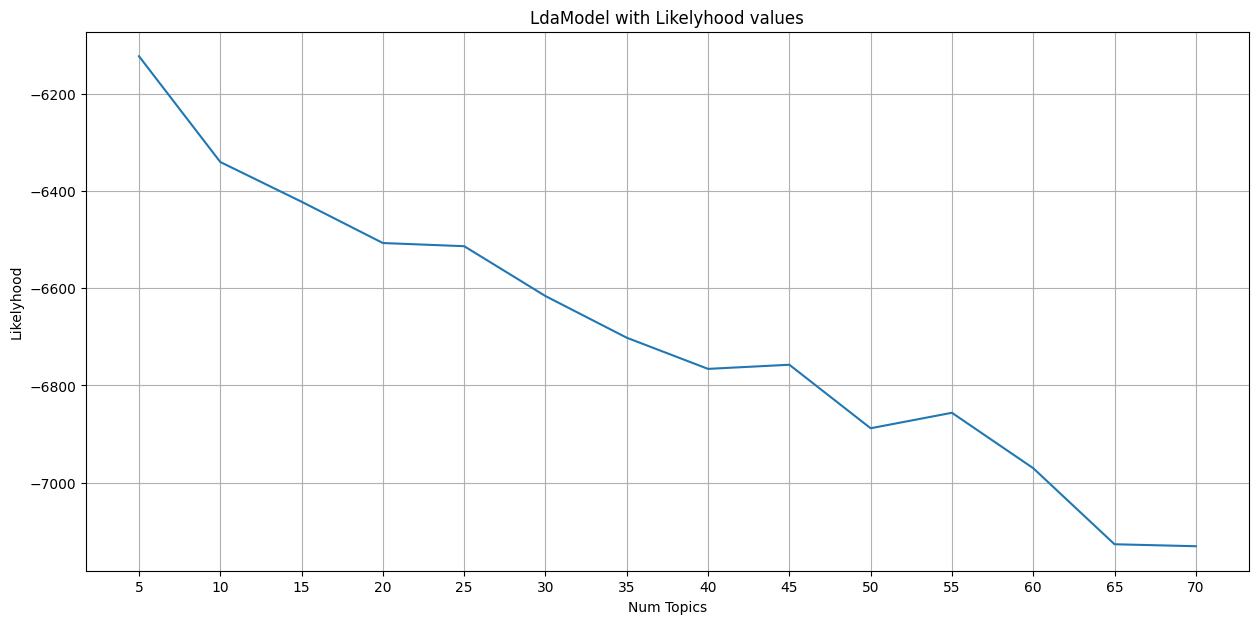

In [12]:
x = range(start, limit, step)
plt.figure(figsize=(15, 7))
plt.plot(x, Likelyhood_values)
plt.xticks(x)
plt.grid()
plt.xlabel("Num Topics")
plt.ylabel("Likelyhood")
plt.title("LdaModel with Likelyhood values")
plt.savefig("./results/LdaModel with Likelyhood values.png")

In [13]:
Likelyhood_values

[-6122.556588331341,
 -6340.218608060479,
 -6422.004958926523,
 -6506.984116818696,
 -6513.486910120814,
 -6616.091371227022,
 -6701.861553428551,
 -6765.969027377529,
 -6757.445101809479,
 -6888.147140758521,
 -6856.304038340265,
 -6970.30437047699,
 -7126.850048901937,
 -7130.905544988049]

## perplexity

In [14]:
perplexity_values = []
limit = 75
start = 5
step = 5
for num_topics in range(start, limit, step):
    print(num_topics)
    lda_model = LatentDirichletAllocation(n_components=num_topics,               # Number of topics
                                      max_iter=40,               # Max learning iterations
                                      learning_method='batch',   
                                      random_state=888,          # Random state
                                      batch_size=2,            # n docs in each learning iter
                                      evaluate_every = 3,       # compute perplexity every n iters, default: Don't
                                    perp_tol  = 0.001,
                                      n_jobs = -1,               # Use all available CPUs
                                     )
    lda_output = lda_model.fit_transform(data_vectorized)
    perplexity_values.append(lda_model.perplexity(data_vectorized,sub_sampling=True))

5
10
15
20
25
30
35
40
45
50
55
60
65
70


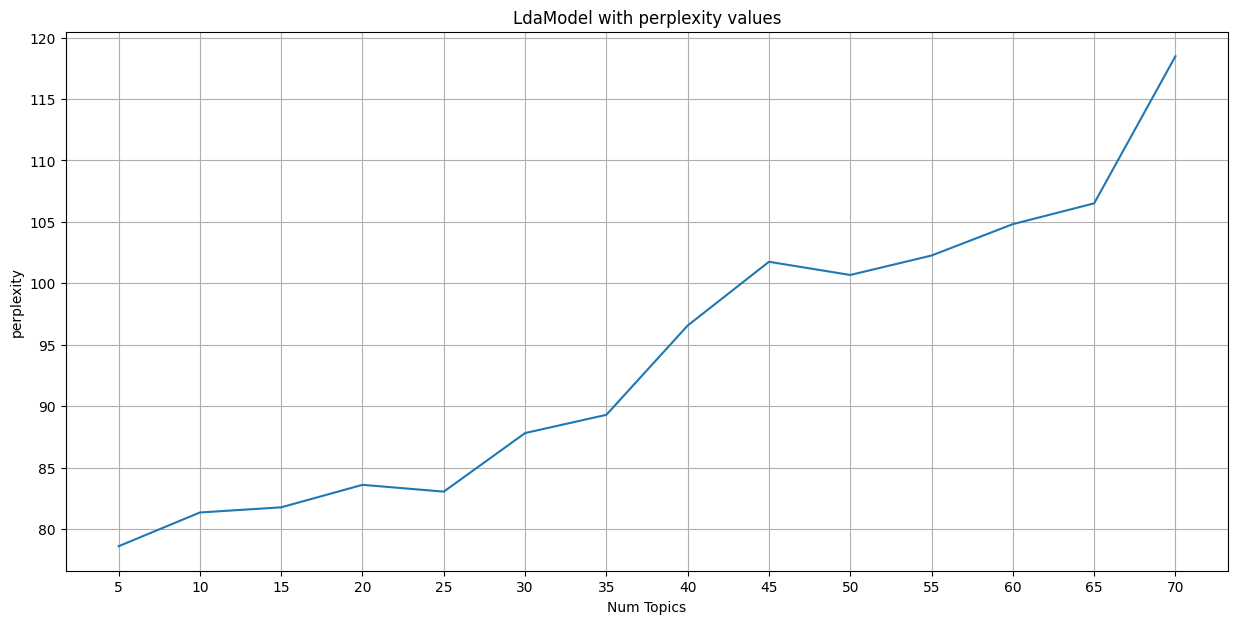

In [15]:
x = range(start, limit, step)
plt.figure(figsize=(15, 7))
plt.plot(x, perplexity_values)
plt.xticks(x)
plt.grid()
plt.xlabel("Num Topics")
plt.ylabel("perplexity")
plt.title("LdaModel with perplexity values")
plt.savefig("./results/LdaModel with perplexity values.png")

In [16]:
perplexity_values

[78.59311290965664,
 81.33930292749575,
 81.75989408223032,
 83.59149363424399,
 83.0364448095411,
 87.80676464996104,
 89.29117499787253,
 96.56028827628292,
 101.75112922290853,
 100.67584399739619,
 102.26051857412165,
 104.81554467261859,
 106.50657449140309,
 118.48617055878653]